<a href="https://colab.research.google.com/github/boltikpravyi/rct_hw/blob/main/RCT_Interactive_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Food for Thought: Evidence from a Randomized Controlled Trial**



### **Install and load packages needed for a reproduction of the results**

In [49]:
install.packages('openxlsx')
install.packages('MatchIt')
install.packages('sandwich')
install.packages('lmtest')
install.packages('BiocManager')
BiocManager::install('graph')
BiocManager::install('RBGL')
install.packages('pcalg')
install.packages('modelsummary')
install.packages('marginaleffects')
install.packages('AER')
install.packages('crch')
BiocManager::install('Rgraphviz')

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'Rgraphviz'

Old packages: 'data.table', 'evaluate'



In [50]:
library(openxlsx) # load excel files
library(tidyverse) # data science packages
library(AER) # censored regression model
library(crch) # censored regression w/ heteroscedastic errors
library(MatchIt) # matching algorithms
library(sandwich) # robust standard errors
library(lmtest) # tests for estimated coefficients
library(pcalg) # Peter-Clark causal discovery algorithm
library(modelsummary) # representation of models' results
library(marginaleffects) # calculate marginal effects from models
library(Rgraphviz) # plot causal graphs

Loading required package: graph

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘graph’


The following object is masked from ‘package:stringr’:

    boundary


Loading required package: grid


Attaching package: ‘Rgraphviz’

### **Load and transform data**

In [54]:
# Load data
file <- 'https://raw.githubusercontent.com/boltikpravyi/rct_hw/main/data.xlsx'
rawdata <- read.xlsx(file, sheet = 1)

# Transform data
df <- rawdata %>%
  rename(ID = 'ID.пациента',
         D = 'T') %>%
  mutate(Yr = round(Y, 2)) %>% # for censored regression estimates
  mutate(Label = as_factor(D)) %>%
  mutate(X2 = X^2, X3 = X^3, X4 = X^4, X5 = X^5, X6 = X^6) %>%
  mutate(Xc = X - mean(X), X2c = X2 - mean(X2), X3c = X3 - mean(X3),
         X4c = X4 - mean(X4), X5c = X5 - mean(X5), X6c = X6 - mean(X6))

# Matching treatment and control
estMatch <- matchit(D ~ Xc, data = df, method = 'nearest') # 1:1 greedy NN on the PS
dfMatch <- (df %>% dplyr::filter(ID %in% as.numeric(estMatch$match.matrix[,1]))) %>%
  bind_rows(df %>% dplyr::filter(D == 1)) %>%
  mutate(X2 = X^2, X3 = X^3, X4 = X^4, X5 = X^5, X6 = X^6) %>%
  mutate(Xc = X - mean(X), X2c = X2 - mean(X2), X3c = X3 - mean(X3),
         X4c = X4 - mean(X4), X5c = X5 - mean(X5), X6c = X6 - mean(X6))

head(df)

,ID,Y,D,X,Yr,Label,X2,X3,X4,X5,X6,Xc,X2c,X3c,X4c,X5c,X6c
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,8.286189,0,10.905067,8.29,0,118.92049,1296.8359,14142.082,154220.35,1681783.3,0.2882851,3.330144,10.86469,-431.3318,-13570.829,-276712.661
2,2,8.727358,0,13.774213,8.73,0,189.72895,2613.3670,35997.074,495831.38,6829687.1,3.1574313,74.138608,1327.39582,21423.6605,328040.197,4871191.174
3,3,8.225626,0,11.683802,8.23,0,136.51124,1594.9703,18635.317,217731.36,2543930.2,1.0670204,20.920894,308.99911,4061.9037,49940.185,585434.293
4,4,8.210367,0,11.514580,8.21,0,132.58554,1526.6668,17578.926,202413.94,2330711.4,0.8977976,16.995200,240.69559,3005.5121,34622.760,372215.486
5,5,8.224029,0,11.188332,8.22,0,125.17878,1400.5418,15669.726,175318.10,1961517.2,0.5715503,9.588436,114.57057,1096.3126,7526.925,3021.277
6,6,8.838721,0,9.927909,8.84,0,98.56337,978.5281,9714.737,96447.02,957517.2,-0.6888734,-17.026974,-307.44308,-4858.6763,-71344.155,-1000978.681


**ID** — identification number of a patient

**Y** — post-treatment health outcome

**D** — indicator of treatment (1) and control (0) group

**X** — pre-treatment thousands of steps per day

**Yr** — outcome rounded to 2 digits (for censored regressions)

**Label** — factor type of a treatment (for grouping in figures/tables)

**X2, X3, X4, X5, X6** — polynomial features for a pre-treatment indicator

**Xc, X2c, X3c, X4c, X5c, X6c** — centered polynomial features (such as $\widehat{E(X)}=0$)

### **Exploratory data analysis**

Number of treated (1) and untreated (0)

In [55]:
df %>%
  group_by(D) %>%
  summarise(Y = n())

D,Y
<dbl>,<int>
0,1993
1,507


Distribution of observed outcome (looks like Y has a censored distribution):

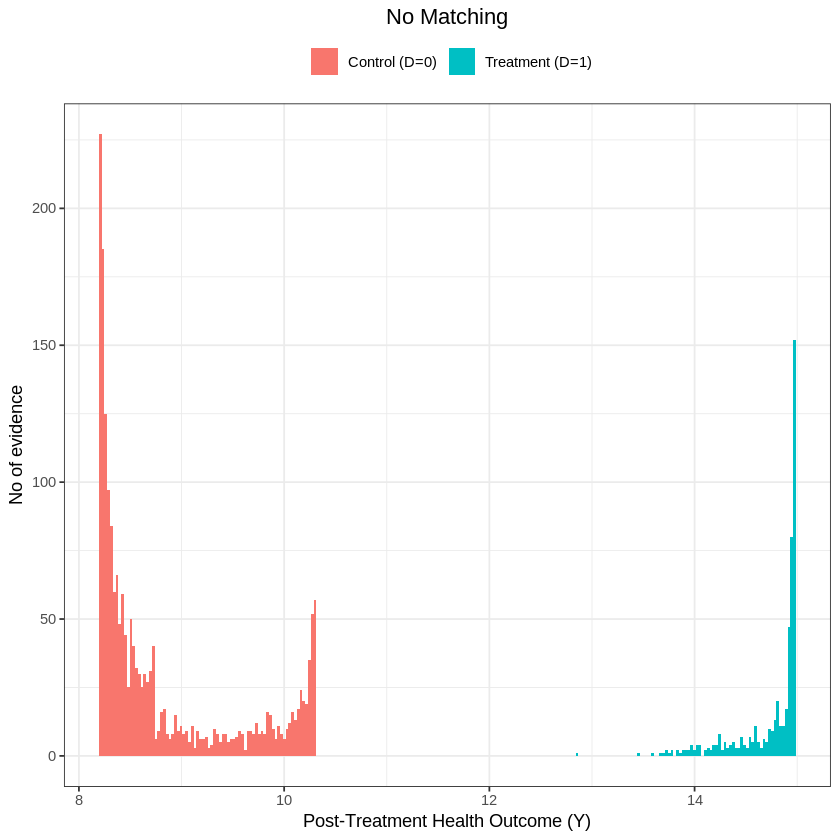

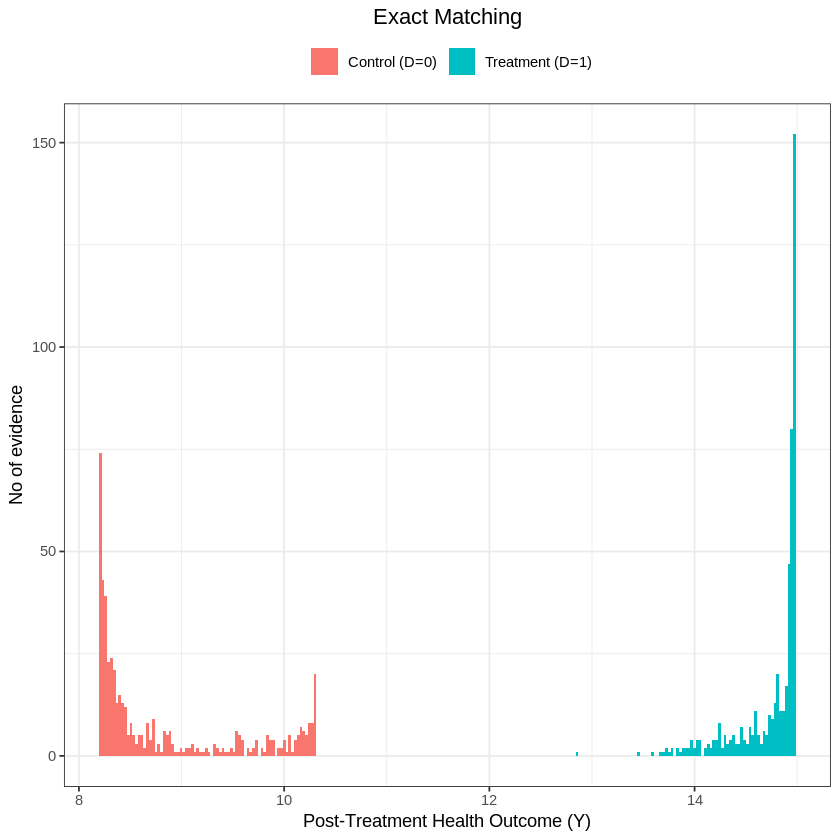

In [56]:
df %>%
  ggplot(mapping = aes(x = Y, fill = Label)) +
    geom_histogram(bins = 250) +
    theme_bw() +
    theme(legend.position = 'top', plot.title = element_text(hjust = 0.5)) +
    labs(x = 'Post-Treatment Health Outcome (Y)', y = 'No of evidence', title = 'No Matching') +
    scale_fill_discrete(name = '', labels = c('Control (D=0)', 'Treatment (D=1)'))
dfMatch %>%
  ggplot(mapping = aes(x = Y, fill = Label)) +
  geom_histogram(bins = 250) +
  theme_bw() +
  theme(legend.position = 'top', plot.title = element_text(hjust = 0.5)) +
  labs(x = 'Post-Treatment Health Outcome (Y)', y = 'No of evidence', title = 'Exact Matching') +
  scale_fill_discrete(name = '', labels = c('Control (D=0)', 'Treatment (D=1)'))

A dataframe of descriptive statistics for Y and X

In [57]:
desc <- df %>%
  select(-ID) %>%
  group_by(D) %>%
  summarise(n = n(),
            distinct_y = n_distinct(Y),
            mean_y = mean(Y), sd_y = sd(Y),
            min_y = min(Y), max_y = max(Y),
            median_y = median(Y),
            distinct_x = n_distinct(X),
            mean_x = mean(X), sd_x = sd(X),
            min_x = min(X), max_x = max(X),
            median_x = median(Xc))
descMatch <- dfMatch %>%
  select(-ID) %>%
  group_by(D) %>%
  summarise(n = n(),
            distinct_y = n_distinct(Y),
            mean_y = mean(Y), sd_y = sd(Y),
            min_y = min(Y), max_y = max(Y),
            median_y = median(Y),
            distinct_x = n_distinct(X),
            mean_x = mean(X), sd_x = sd(X),
            min_x = min(X), max_x = max(X),
            median_x = median(X))

Descriptive statistics table of unmatched observations...

In [58]:
desc %>%
  select(D, n, mean_y, sd_y, min_y, max_y, median_y)
desc %>%
  select(D, n, mean_x, sd_x, min_x, max_x, median_x)

D,n,mean_y,sd_y,min_y,max_y,median_y
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1993,8.818815,0.7147146,8.208227,10.29938,8.467238
1,507,14.754604,0.3272136,12.861451,14.97542,14.924875


D,n,mean_x,sd_x,min_x,max_x,median_x
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1993,10.62614,1.710669,5.388568,14.79805,0.3297058
1,507,10.58000,1.636712,5.647615,13.79642,0.3852790


...and for matched observations

In [59]:
descMatch %>%
  select(D, n, mean_y, sd_y, min_y, max_y, median_y)
descMatch %>%
  select(D, n, mean_x, sd_x, min_x, max_x, median_x)

D,n,mean_y,sd_y,min_y,max_y,median_y
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,507,8.813968,0.7296771,8.208229,10.29938,8.414825
1,507,14.754604,0.3272136,12.861451,14.97542,14.924875


D,n,mean_x,sd_x,min_x,max_x,median_x
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,507,10.5808,1.636450,5.636950,13.80947,11.00255
1,507,10.5800,1.636712,5.647615,13.79642,11.00206


**D=1** for treatment group and **D=0** for control group

**n** — number of observation in each group

**mean_** — sample average value across groups

**sd_** — sample standard deviation in each group

**min_** and **max_** — minimum and maximum, respectively

**median_** — 50% quantile of sample distribution

Above we can see that even in an unmatched dataset pre-treatment patients' characteristics have a similar distribution across treatment and control group

Same pattern we can see just plotting the distribution

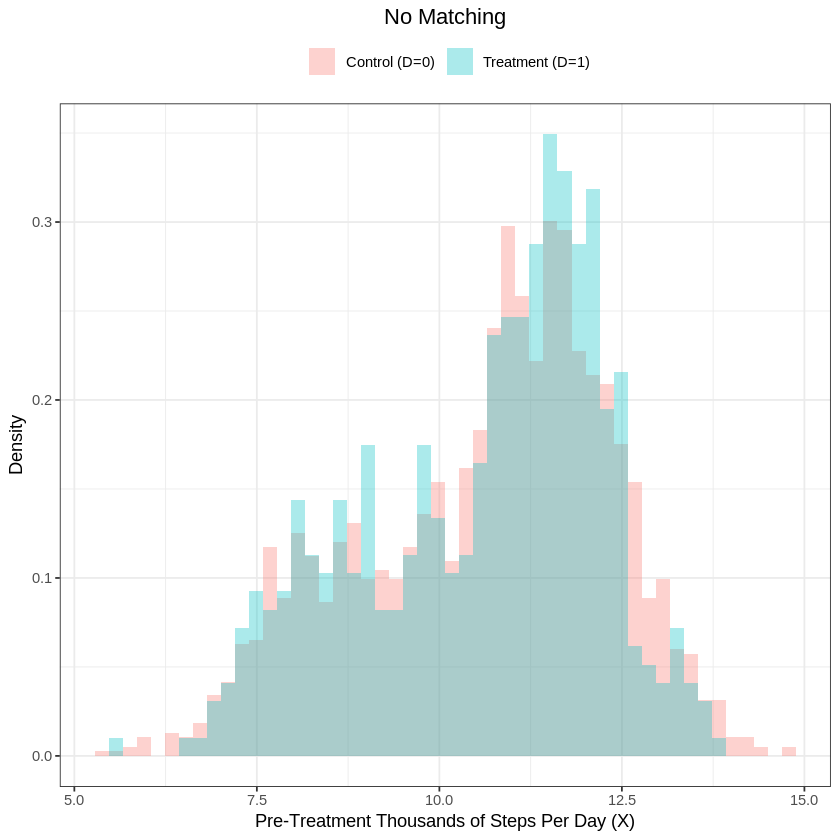

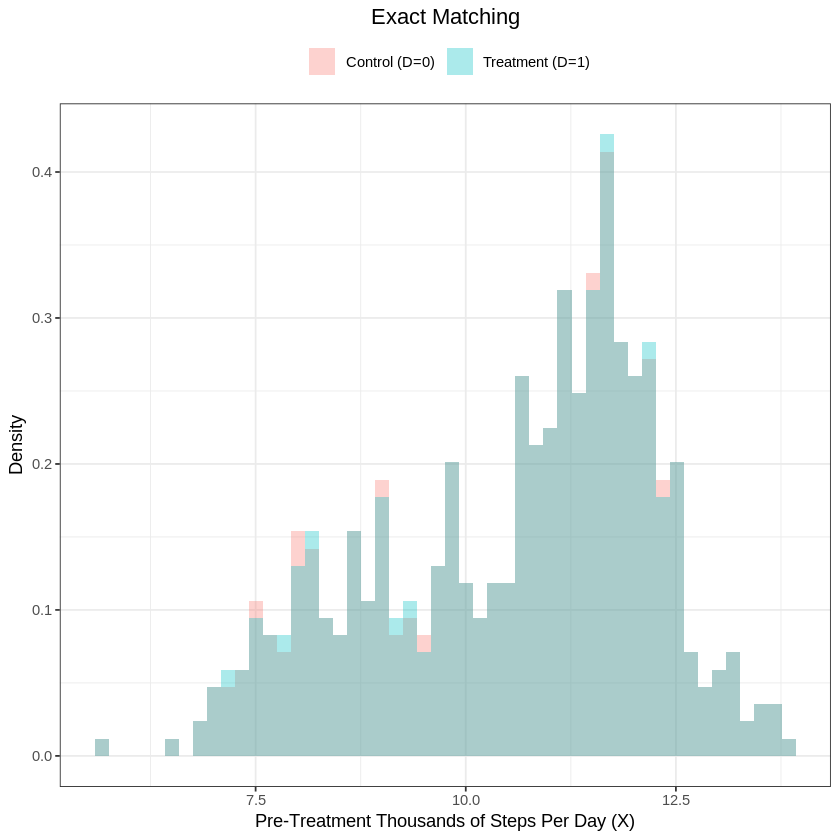

In [60]:
df %>%
  ggplot(mapping = aes(x = X, fill = Label)) +
  geom_histogram(aes(y = after_stat(density)), position = 'identity', alpha = 0.33, bins = 50) +
  theme_bw() +
  theme(legend.position = 'top', plot.title = element_text(hjust = 0.5)) +
  labs(x = 'Pre-Treatment Thousands of Steps Per Day (X)', y = 'Density', title = 'No Matching') +
  scale_fill_discrete(name = '', labels = c('Control (D=0)', 'Treatment (D=1)'))
dfMatch %>%
  ggplot(mapping = aes(x = X, fill = Label)) +
  geom_histogram(aes(y = after_stat(density)), position = 'identity', alpha = 0.33, bins = 50) +
  theme_bw() +
  theme(legend.position = 'top', plot.title = element_text(hjust = 0.5)) +
  labs(x = 'Pre-Treatment Thousands of Steps Per Day (X)', y = 'Density', title = 'Exact Matching') +
  scale_fill_discrete(name = '', labels = c('Control (D=0)', 'Treatment (D=1)'))

More strictly, we can estimate the regression of treatment variable D on patients' characteristics X to see that D is exogenous with respect to X
Hence, it really was an RCT and there's no selection bias

In [61]:
models <- list('Panel A: No Matching' = list('OLS' = lm(D ~ X, data = df)),
               'Panel B: Exact Matching' = list('OLS' = lm(D ~ X, data = dfMatch)))
modelsummary(models, shape = 'cbind', vcov = 'HC3', coef_rename = c('X' = 'No. of steps (X)'),
              statistic = c('conf.int', 's.e. = {std.error}', 't = {statistic}', 'p = {p.value}'),
              conf_level = .99, gof_omit = c('IC|RMSE|Log|R2$'))

+------------------+----------------------+-------------------------+
|                  | Panel A: No Matching | Panel B: Exact Matching |
+------------------+----------------------+-------------------------+
|                  | OLS                  | OLS                     |
+==================+======================+=========================+
| (Intercept)      | 0.230                | 0.501                   |
+------------------+----------------------+-------------------------+
|                  | [0.102, 0.359]       | [0.235, 0.767]          |
+------------------+----------------------+-------------------------+
|                  | s.e. = 0.050         | s.e. = 0.103            |
+------------------+----------------------+-------------------------+
|                  | t = 4.617            | t = 4.854               |
+------------------+----------------------+-------------------------+
|                  | p = <0.001           | p = <0.001              |
+------------------+

Now, let's look at the association between outcome Y and pre-treatment patients' characteristics X

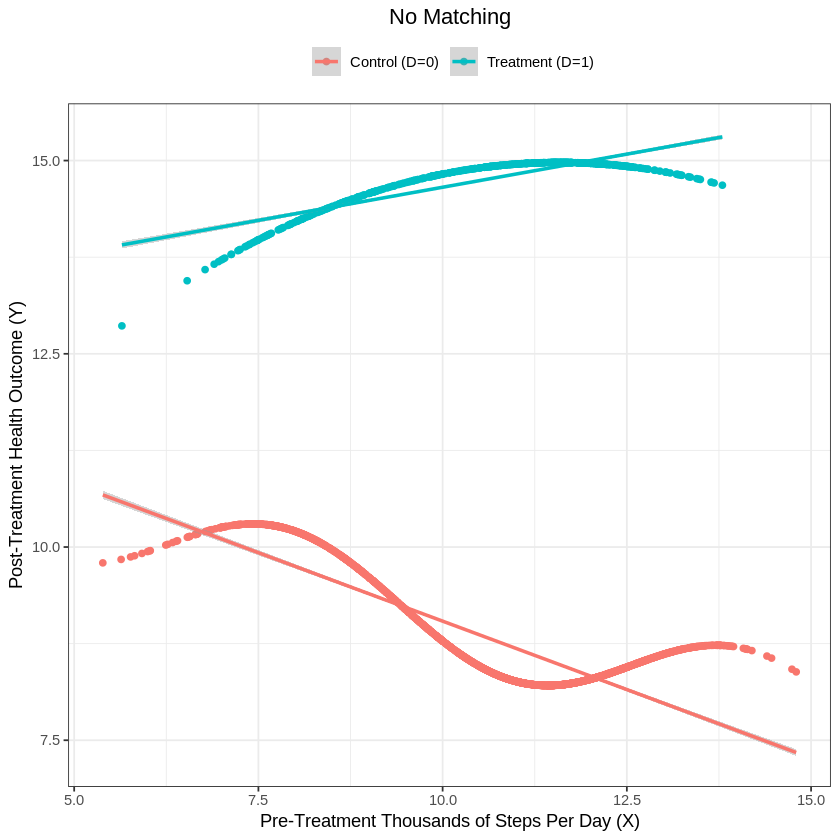

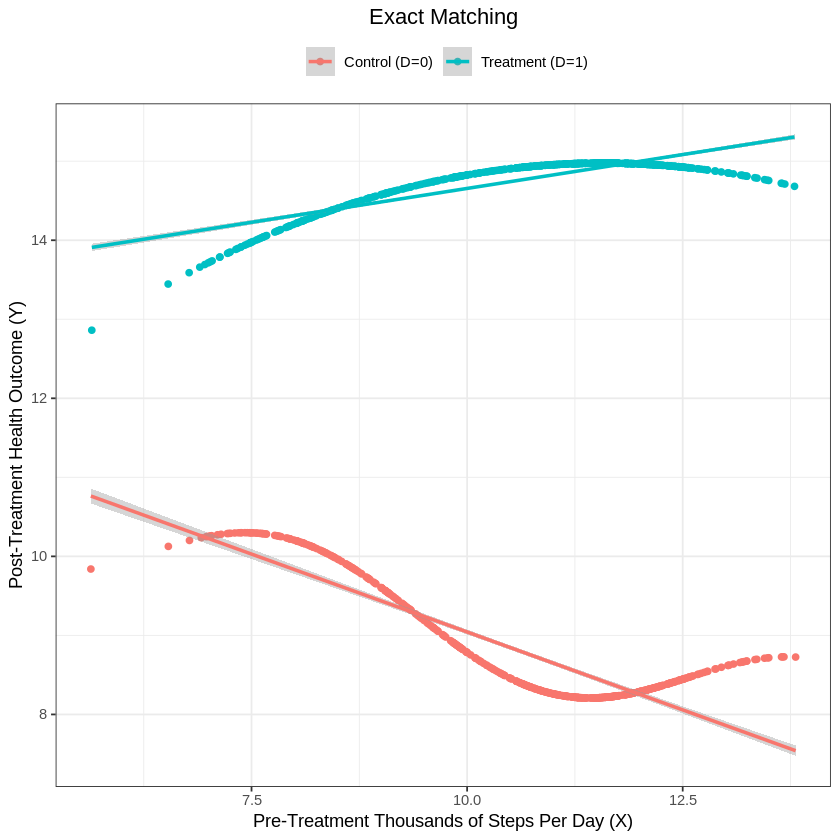

In [62]:
df %>%
  ggplot(mapping = aes(x = X, y = Y, color = Label)) +
  geom_point() +
  stat_smooth(method = 'lm', formula = y ~ x, geom = 'smooth') +
  theme_bw() +
  theme(legend.position = 'top', plot.title = element_text(hjust = 0.5)) +
  labs(x = 'Pre-Treatment Thousands of Steps Per Day (X)', y = 'Post-Treatment Health Outcome (Y)', title = 'No Matching') +
  scale_color_discrete(name = '', labels = c('Control (D=0)', 'Treatment (D=1)'))
dfMatch %>%
  ggplot(mapping = aes(x = X, y = Y, color = Label)) +
  geom_point() +
  stat_smooth(method = 'lm', formula = y ~ x, geom = 'smooth') +
  theme_bw() +
  theme(legend.position = 'top', plot.title = element_text(hjust = 0.5)) +
  labs(x = 'Pre-Treatment Thousands of Steps Per Day (X)', y = 'Post-Treatment Health Outcome (Y)', title = 'Exact Matching') +
  scale_color_discrete(name = '', labels = c('Control (D=0)', 'Treatment (D=1)'))

Make causal discovery procedure to understand connections between variables

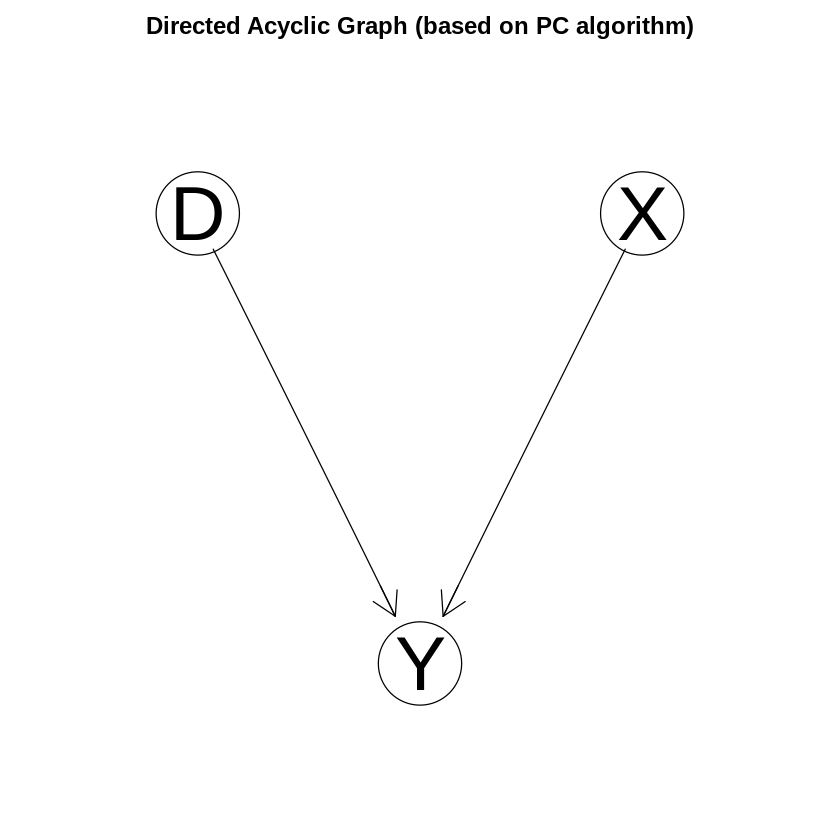

In [63]:
suff_stat <- list(C = cor(df[,2:4]), n = nrow(df[,2:4]))
estPC <- pc(suff_stat, indepTest = gaussCItest, labels = colnames(df[,2:4]), alpha = 0.01, skel.method = 'stable.fast')
plot(estPC, main = 'Directed Acyclic Graph (based on PC algorithm)')

### **Estimation of Population Average Treatment Effect (PATE) and its precision**

In [64]:
# OLS estimators (no matching)
estOLS <- lm(Y ~ D, data = df) # Diff-in-means estimator
mefOLS <- avg_slopes(estOLS, variables = 'D', vcov = 'HC3') # robust statistical inference (Eicker-Huber-White s.e.)
estOLSControl <- lm(Y ~ D + Xc*D + X2c*D + X3c*D, data = df) # interaction term always improves the precision of ATE (Lin, 2013)
mefOLSControl <- avg_slopes(estOLSControl, variables = 'D', vcov = 'HC3')

# OLS estimators (exact matching)
estOLSMatch <- lm(Y ~ D, data = dfMatch)
mefOLSMatch <- avg_slopes(estOLSMatch, variables = 'D', vcov = 'HC3')
estOLSMatchControl <- lm(Y ~ D + Xc*D + X2c*D + X3c*D, data = dfMatch)
mefOLSMatchControl <- avg_slopes(estOLSMatchControl, variables = 'D', vcov = 'HC3')

# Censored ML estimators (no matching)
estCens <- tobit(Yr ~ D, data = df, left = min(df$Yr), right = max(df$Yr), robust = T)
mefCens <- avg_slopes(estCens, variables = 'D')
estCensControl <- tobit(Yr ~ D + Xc*D + X2c*D + X3c*D, data = df, left = min(df$Yr), right = max(df$Yr), robust = T)
mefCensControl <- avg_slopes(estCensControl, variables = 'D')

# Censored ML estimators (exact matching)
estCensMatch <- tobit(Yr ~ D, data = dfMatch, left = min(dfMatch$Yr), right = max(dfMatch$Yr), robust = T)
mefCensMatch <- avg_slopes(estCensMatch, variables = 'D')
estCensMatchControl <- tobit(Yr ~ D + Xc*D + X2c*D + X3c*D, data = dfMatch, left = min(dfMatch$Yr), right = max(dfMatch$Yr), robust = T)
mefCensMatchControl <- avg_slopes(estCensMatchControl, variables = 'D')

# Censored ML Estimators w/ heteroscedastic errors
estCensHC <- crch(Yr ~ D | D + Xc + X2c + X3c + X4c, data = df, left = min(df$Yr), right = max(df$Yr))
mefCensHC <- avg_slopes(estCensHC, variables = 'D')
estCensHCMatch <- crch(Yr ~ D | D + Xc + X2c + X3c + X4c, data = dfMatch, left = min(dfMatch$Yr), right = max(dfMatch$Yr))
mefCensHCMatch <- avg_slopes(estCensHCMatch, variables = 'D')

Finally, let's get the results of the estimation

In [65]:
mefs <- list(
  'Panel A: No matching' = list(
    'OLS' = mefOLS,
    'OLS w/ X' = mefOLSControl,
    'CR' = mefCens,
    'CR w/ X' = mefCensControl,
    'CR w/ het. err.' = mefCensHC),
  'Panel B: Exact matching' = list(
    'OLS' = mefOLSMatch,
    'OLS w/ X' = mefOLSMatchControl,
    'CR' = mefCensMatch,
    'CR w/ X' = mefCensMatchControl,
    'CR w/ het. err.' = mefCensHCMatch))
modelsummary(mefs, shape = 'rbind', stars = T, statistic = c('s.e. = {std.error}', 'conf.int'),
             coef_rename = c('D' = 'PATE, point estimate'), conf_level = .99,
             gof_omit = c('IC|Log|R2|F|Std|r2'))

+----------------------+----------------+----------------+----------------+----------------+-----------------+
|                      | OLS            | OLS w/ X       | CR             | CR w/ X        | CR w/ het. err. |
+======================+================+================+================+================+=================+
| Panel A: No matching                                                                                       |
+----------------------+----------------+----------------+----------------+----------------+-----------------+
| PATE, point estimate | 5.936***       | 5.931***       | 5.997***       | 5.947***       | 6.333***        |
+----------------------+----------------+----------------+----------------+----------------+-----------------+
|                      | s.e. = 0.022   | s.e. = 0.003   | s.e. = 0.023   | s.e. = 0.004   | s.e. = 0.009    |
+----------------------+----------------+----------------+----------------+----------------+-----------------+
|